# Business Understanding

**Background**

New York City (NYC) has one of the world's largest and busiest public transit systems, where taxis play a vital role in providing quick, flexible transportation options to fill transit gaps.

**Problem Statement**

In the taxi industry, understanding demand patterns, regional preferences, and factors like tipping is crucial to optimize operations and profitability. Identifying when and where services are needed, as well as factors that influence customer appreciation, enables companies to make informed decisions on resource allocation, pricing, and customer service strategies.

**Goals**

Provide insights to stakeholders to:
- Improve taxi fleet distribution based on demand, reducing costs.
- Enhance customer satisfaction by meeting preferences and needs.
- Boost revenue by adjusting pricing and services based on regional trends.
- Identify drivers of customer appreciation, like tipping behavior.


# Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
import calendar
import time

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 30)
color = sns.color_palette("Paired")
scale = 'coolwarm_r'

# Load Dataset

In [ ]:
import io
from google.colab import files
uploaded = files.upload()
clean_data = pd.read_csv(io.BytesIO(uploaded['NYC TLC Trip Record - Clean.csv']))

Saving NYC TLC Trip Record - Clean.csv to NYC TLC Trip Record - Clean.csv


In [ ]:
df = clean_data.copy()
df.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,day_category,pickup_time,RatecodeID,PULocationID,PUBorough,PUZone,DOLocationID,DOBorough,DOZone,passenger_count,trip_distance,distance_bins,fare_amount,fare_amount_bins,tip_amount,tip_amount_bins,payment_type,trip_type,trip_duration,duration_bins,speed,speed_bins
0,2023-01-01 00:26:10,2023-01-01 00:37:11,Weekend,Midnight,Standard rate,166,Manhattan,Morningside Heights,143,Manhattan,Lincoln Square West,1.0,2.58,3-6 miles,14.9,<20$,4.03,1-5$,Credit card,Street-hail,11.02,11-20 minutes,14.05,11-20 mph
1,2023-01-01 00:51:03,2023-01-01 00:57:49,Weekend,Midnight,Standard rate,24,Manhattan,Bloomingdale,43,Manhattan,Central Park,1.0,1.81,<2 miles,10.7,<20$,2.64,1-5$,Credit card,Street-hail,6.77,<10 minutes,16.04,11-20 mph
2,2023-01-01 00:13:14,2023-01-01 00:19:03,Weekend,Midnight,Standard rate,41,Manhattan,Central Harlem,238,Manhattan,Upper West Side North,1.0,1.30,<2 miles,6.5,<20$,1.70,1-5$,Credit card,Street-hail,5.82,<10 minutes,13.40,11-20 mph
3,2023-01-01 00:33:04,2023-01-01 00:39:02,Weekend,Midnight,Standard rate,41,Manhattan,Central Harlem,74,Manhattan,East Harlem North,1.0,1.10,<2 miles,6.0,<20$,0.00,0$,Credit card,Street-hail,5.97,<10 minutes,11.06,11-20 mph
4,2023-01-01 00:53:31,2023-01-01 01:11:04,Weekend,Midnight,Standard rate,41,Manhattan,Central Harlem,262,Manhattan,Yorkville East,1.0,2.78,3-6 miles,17.7,<20$,0.00,0$,Cash,Street-hail,17.55,11-20 minutes,9.50,<10 mph


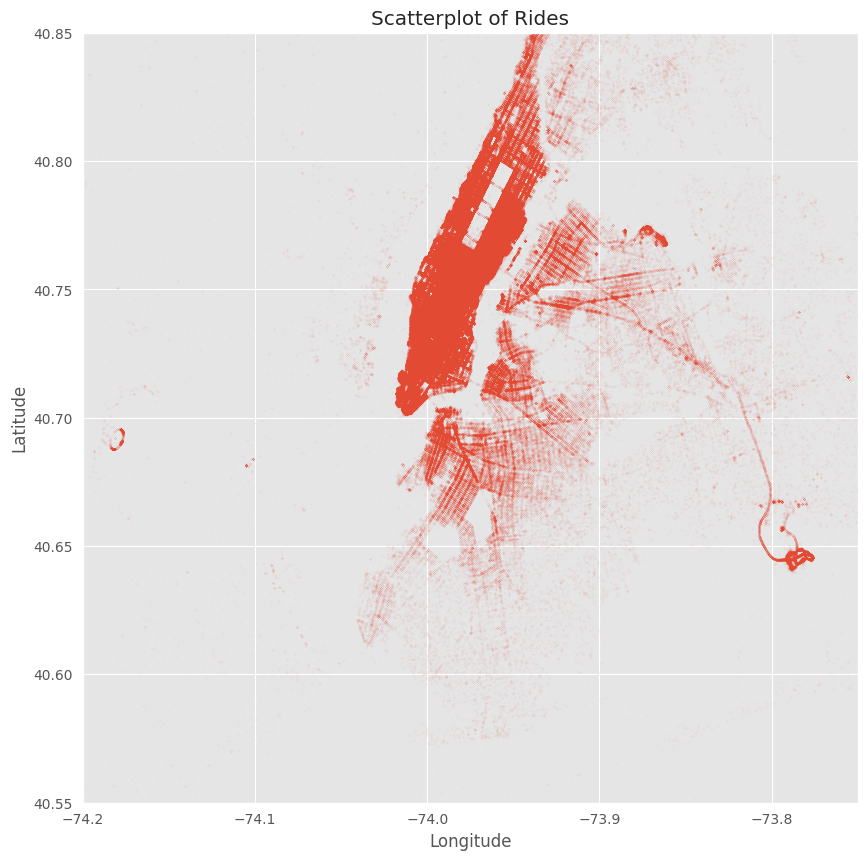

In [ ]:
plt.rcParams['figure.figsize'] = [16, 10]
plt.style.use('ggplot')
longitude = list(dff.pickup_longitude) + list(dff.dropoff_longitude)
latitude = list(dff.pickup_latitude) + list(dff.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.title('Scatterplot of Rides')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(longitude,latitude,'.', alpha = 1, markersize = 0.05)

plt.xlim([-74.2, -73.75])
plt.ylim([40.55, 40.85])

plt.show()

# Exploratory Data Analysis

## Important categorical

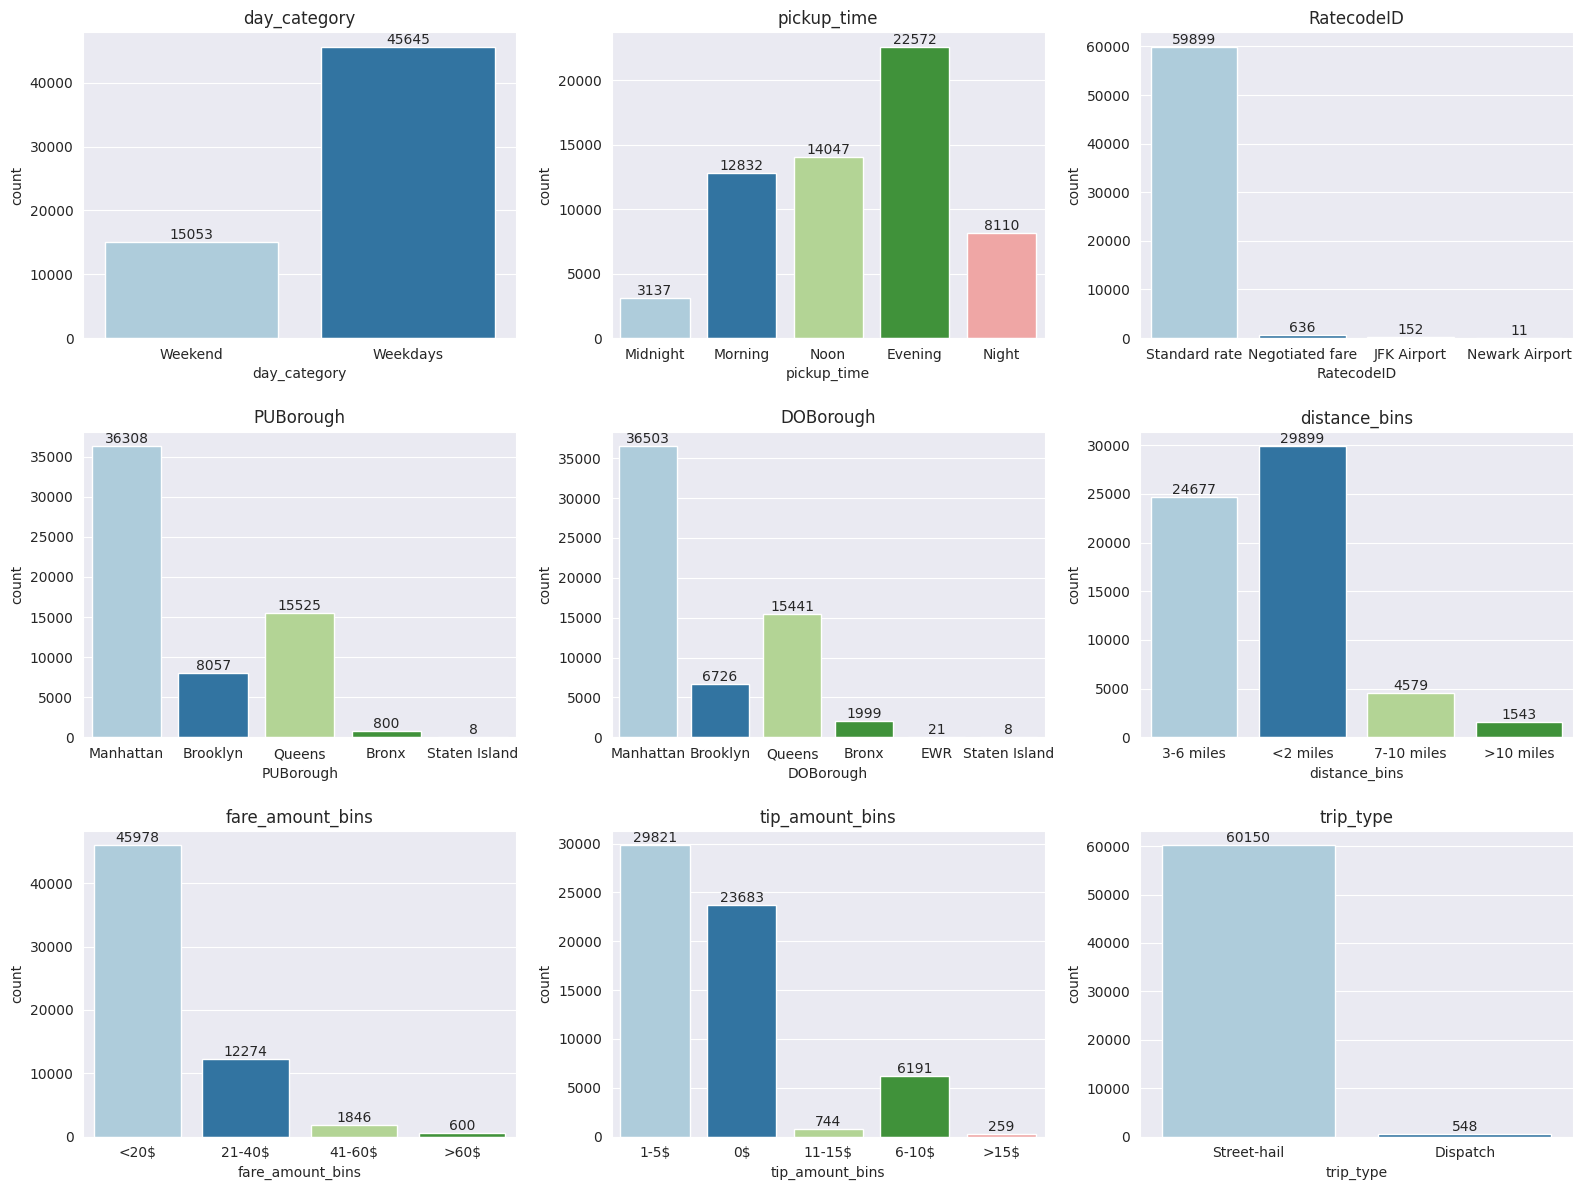

In [ ]:
cols = ['day_category','pickup_time', 'RatecodeID', 'PUBorough', 'DOBorough', 'distance_bins', 'fare_amount_bins', 'tip_amount_bins', 'trip_type']

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16, 12))
axs = axs.flatten()

for i, col in enumerate(cols):
    bars = sns.countplot(data=df, x=col, palette=color, ax=axs[i])
    axs[i].set_title(col)
    for idx, bar in enumerate(bars.patches):
        x_value = bar.get_x() + bar.get_width() / 2
        y_value = bar.get_height()
        label = "{:.0f}".format(bar.get_height())
        axs[i].text(x_value, y_value, label, ha='center', va='bottom')

plt.tight_layout(w_pad=0.5, h_pad=2)
plt.show()

# Data Analysis

In [ ]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

## Demand Based on Time

In [ ]:
trip_monthly = df.groupby(df['lpep_pickup_datetime'].dt.date).agg(trip_bydate=('lpep_pickup_datetime', 'count')).reset_index()
trip_monthly['lpep_pickup_datetime'] = pd.to_datetime(trip_monthly['lpep_pickup_datetime'])
trip_monthly['day_of_week'] = trip_monthly['lpep_pickup_datetime'].dt.day_name()

trip_dayly = trip_monthly.groupby('day_of_week').agg(trip_byday=('trip_bydate', 'sum'), day_count=('day_of_week', 'count'), avg_trip=('trip_bydate', 'mean')).reset_index()
trip_dayly['day_cat']= trip_dayly['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekdays')

trip_dayly_cat = trip_dayly.groupby('day_cat').agg(trip_bycat=('trip_byday', 'sum')).reset_index()

trip_merge = pd.merge(trip_monthly, trip_dayly, on='day_of_week', how='left')
trip_merge = pd.merge(trip_merge, trip_dayly_cat, on='day_cat', how='left')

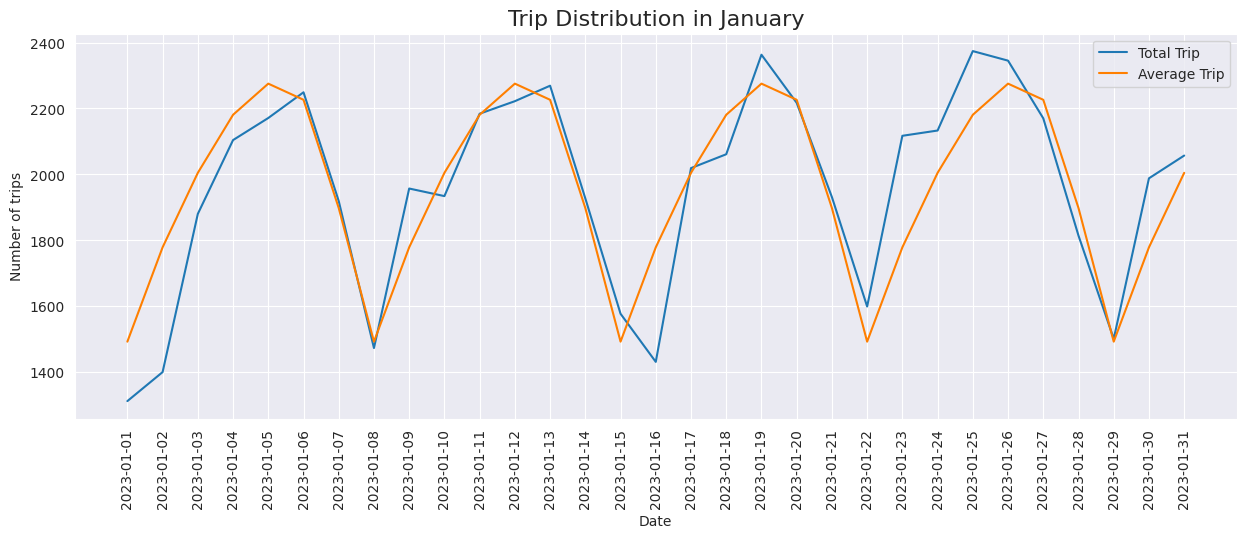

In [ ]:
plt.figure(figsize=(15,5))
sns.set_style('darkgrid')

sns.lineplot(data=trip_merge,
             x='lpep_pickup_datetime',
             y='trip_bydate',
             color=color[1],
             label = 'Total Trip')

sns.lineplot(data=trip_merge,
             x='lpep_pickup_datetime',
             y='avg_trip',
             color=color[7],
             label = 'Average Trip')

plt.title('Trip Distribution in January', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.xticks(trip_monthly['lpep_pickup_datetime'], rotation=90)

plt.show()

`Insights`

- The highest number of taxi trips in January occurred on Wednesday, January 25, 2023.

- While the lowest number of taxi trips in January occurred on Sunday, January 01, 2023.

- There is a repeating pattern in the number of trips in January.

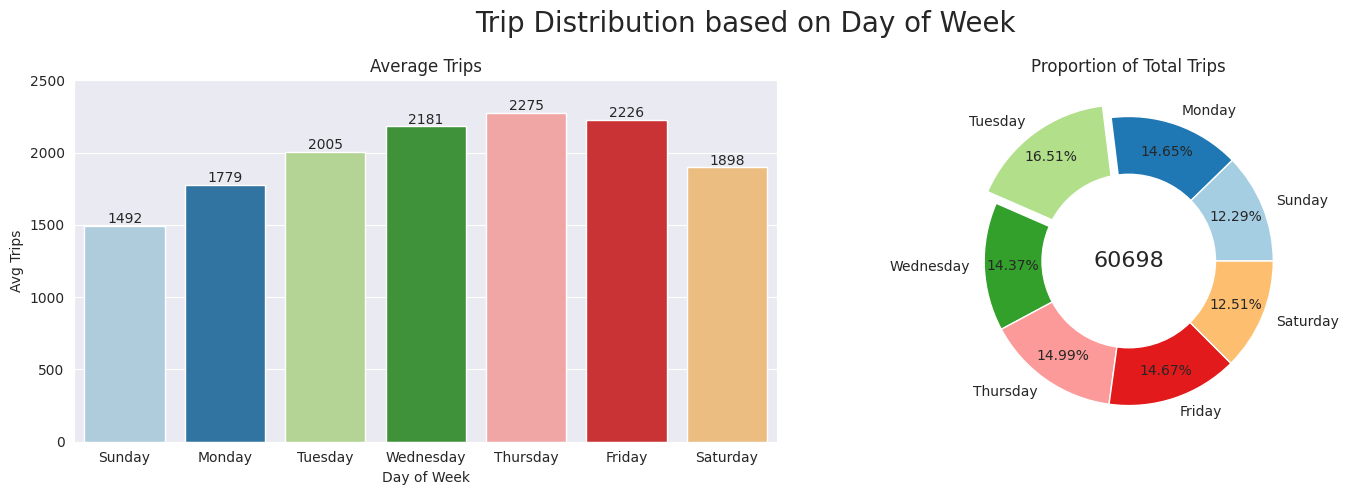

In [ ]:
plt.figure(figsize=(15, 5))
plt.suptitle('Trip Distribution based on Day of Week', fontsize=20)

plt.subplot(1, 2, 1)
bars = sns.barplot(x='day_of_week', y='avg_trip', data=trip_merge, palette=color)
for idx, bar in enumerate(bars.patches):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20,
             f"{trip_merge['avg_trip'].iloc[idx]:.0f}", ha='center')
plt.title('Average Trips')
plt.xlabel('Day of Week')
plt.ylabel('Avg Trips')
plt.yticks(np.arange(0, 2501, 500))

plt.subplot(1, 2, 2)
plt.pie(trip_merge['trip_byday'].unique(),
        labels=trip_merge['day_of_week'].unique(),
        pctdistance=0.8,
        autopct='%1.2f%%',
        explode=(0, 0, 0.1, 0, 0, 0, 0),
        colors=color)
plt.gca().add_artist(plt.Circle((0, 0), 0.6, fc='white'))
plt.text(0, 0, trip_merge['trip_byday'].unique().sum(), ha='center', va='center', fontsize=16)
plt.title('Proportion of Total Trips')

plt.tight_layout()
plt.show()


`Insights`

- The highest proportion of total trips during January was Wednesday, which was 16% of the total number of trips

- However, based on the average number of trips per day, the highest number of trips per day occurred on Thursday, reaching 2275 trips per day

- When entering weekdays, the number of trips consistently increased

- However, when entering the weekend, the number of trips per day decreased quite significantly

In [ ]:
trip_hourly = df.groupby([df['lpep_pickup_datetime'].dt.hour, 'pickup_time']).agg(trip_byhour=('lpep_pickup_datetime', 'count')).reset_index()
trip_bytimecat = df.groupby('pickup_time').agg(trip_bytime=('pickup_time', 'count')).reset_index()
trip_time_merge = pd.merge(trip_hourly, trip_bytimecat, on='pickup_time', how='left')

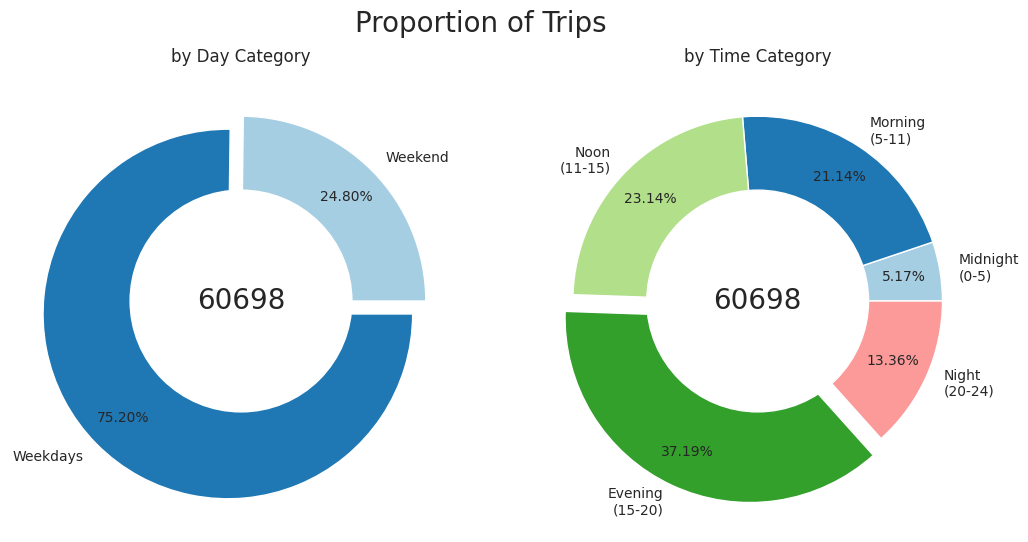

In [ ]:
plt.figure(figsize=(15, 6))
plt.suptitle('Proportion of Trips', fontsize=20)

plt.subplot(1, 2, 1)
plt.pie(trip_merge['trip_bycat'].unique(),
        labels=trip_merge['day_cat'].unique(),
        pctdistance=0.8,
        autopct='%1.2f%%',
        explode=(0, 0.1),
        colors=color)
plt.gca().add_artist(plt.Circle((0, 0), 0.6, fc='white'))
plt.text(0, 0, trip_merge['trip_bydate'].sum(), ha='center', va='center', fontsize=20)
plt.title('by Day Category')

plt.subplot(1, 2, 2)
time_labels = [f"{label}\n{hours}" for label, hours in zip(trip_time_merge['pickup_time'].unique(), ["(0-5)", "(5-11)", "(11-15)", "(15-20)", "(20-24)"])]
plt.pie(trip_time_merge['trip_bytime'].unique(),
        labels=time_labels,
        pctdistance=0.8,
        autopct='%1.2f%%',
        explode=(0, 0, 0, 0.1, 0),
        colors=color)
plt.gca().add_artist(plt.Circle((0, 0), 0.6, fc='white'))
plt.text(0, 0, trip_time_merge['trip_byhour'].sum(), ha='center', va='center', fontsize=20)
plt.title('by Time Category')

plt.subplots_adjust(wspace=-0.2)
plt.show()


`Insights`

- Because the number of trips on weekdays increases and weekends decrease, finally the difference in proportion and number of trips on weekdays and weekends is quite significant.

- The afternoon is the busiest time for taxi trips, reaching 37% of the total trips in January.

- While the time with the lowest number of trips is at midnight starting from 12:00 midnight to 05:00 am with only 5% of the total trips in January.

In [ ]:
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
cross = pd.crosstab(index=df['lpep_pickup_datetime'].dt.day_name(), columns=df['lpep_pickup_datetime'].dt.hour, margins=True).reindex(day_order)
cross.columns.name = None
cross.index.name = 'Day of Week'

melted_cross = cross.iloc[:,:-1].reset_index().melt(id_vars='Day of Week', var_name='hour', value_name='trips')
cross

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
Day of Week,,,,,,,,,,,,,,,,,,,,,,,,,
Sunday,281,264,221,181,137,74,59,96,123,217,324,425,475,490,503,562,539,507,518,442,379,293,193,159,7462
Monday,110,67,49,62,52,51,134,375,418,482,484,508,525,565,580,695,704,704,724,552,378,305,218,151,8893
Tuesday,85,50,44,35,21,51,186,531,648,647,572,529,548,536,650,722,784,775,796,629,456,323,242,163,10023
Wednesday,84,66,27,25,17,43,165,406,510,518,504,452,430,470,535,651,689,747,733,601,408,279,211,152,8723
Thursday,88,61,41,25,31,51,163,424,505,544,508,496,466,498,589,658,699,760,793,543,444,309,240,165,9101
Friday,135,81,38,36,28,42,140,429,463,469,475,454,413,446,594,695,688,710,718,568,421,321,290,251,8905
Saturday,210,176,122,103,84,45,46,108,196,252,354,434,468,514,454,581,567,510,533,475,419,324,315,301,7591


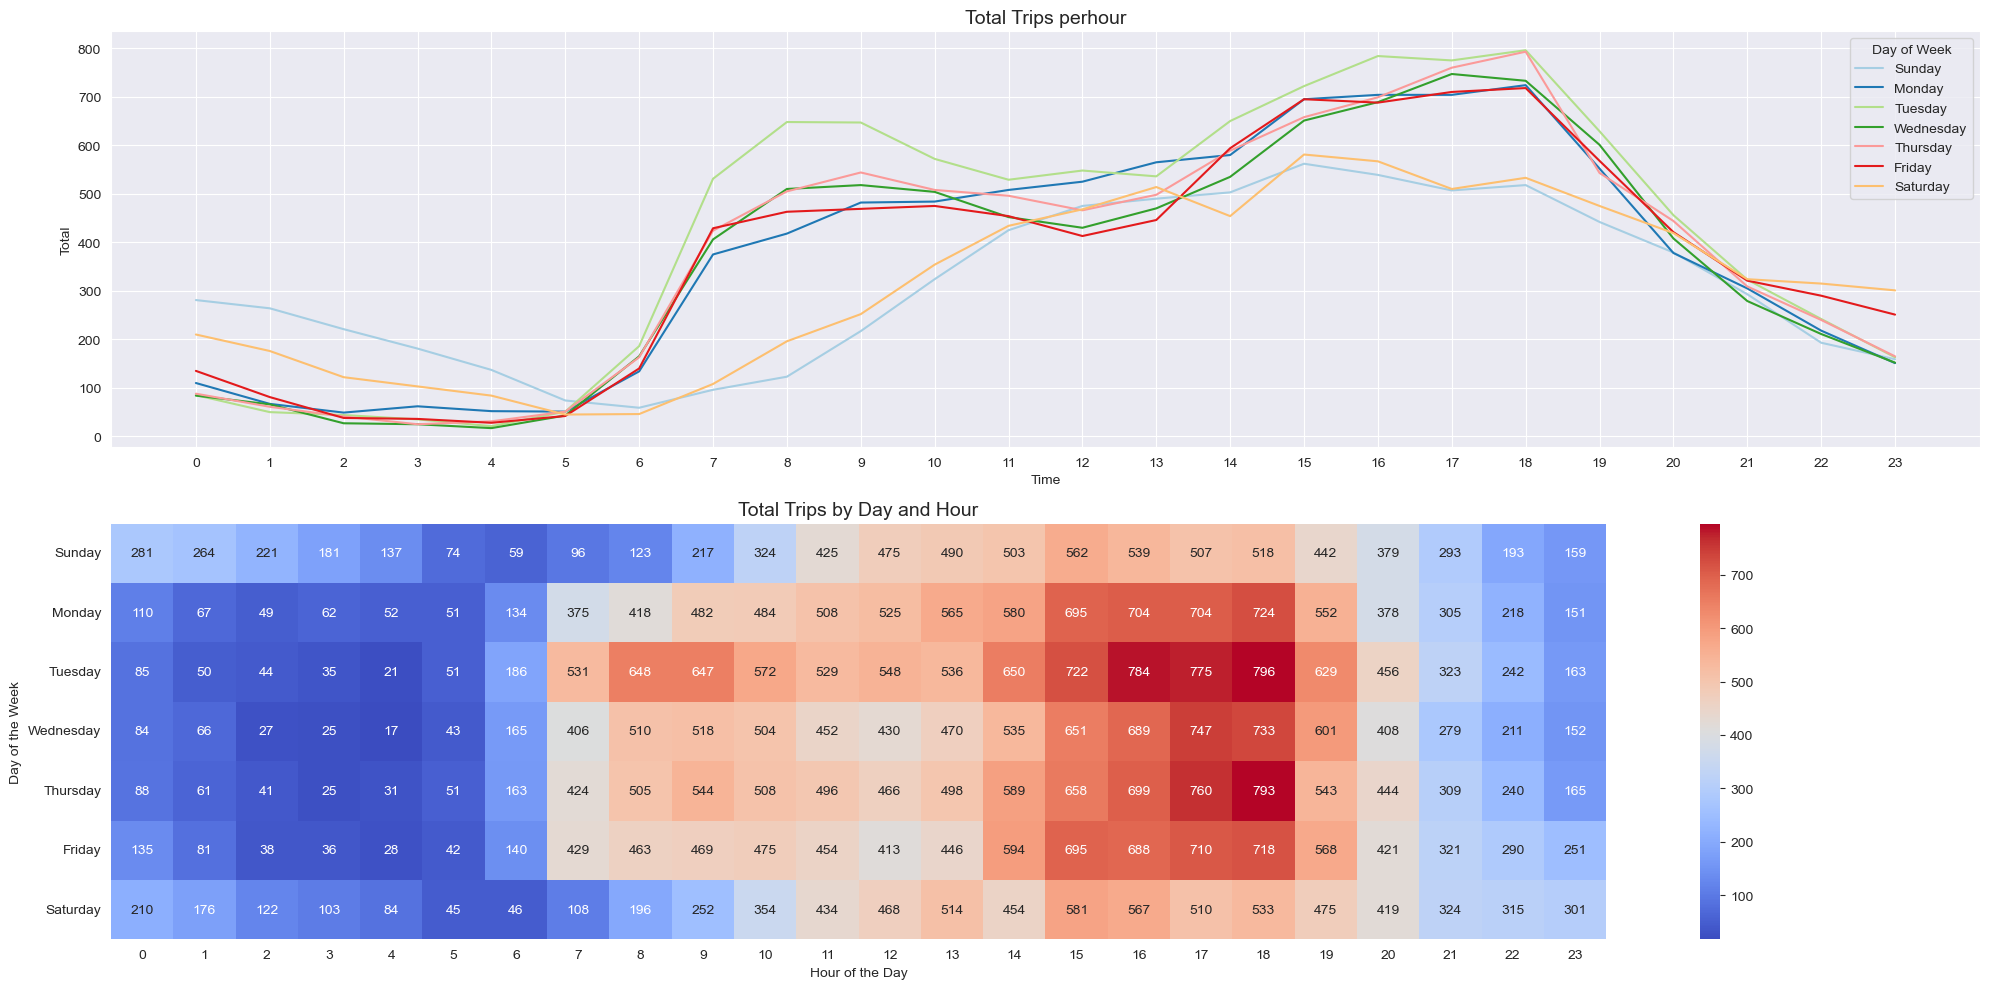

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
sns.lineplot(data=melted_cross,
             x='hour',
             y='trips',
             hue='Day of Week',
             palette=color)

plt.title('Total Trips perhour', fontsize=14)
plt.xlabel('Time')
plt.xticks(np.arange(0,24,1))
plt.ylabel('Total')

plt.subplot(2, 1, 2)
sns.heatmap(cross.iloc[:,:-1], cmap="coolwarm", annot=True, fmt='d')
plt.title('Total Trips by Day and Hour', fontsize=14)
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')

plt.tight_layout()
plt.show()

`Insights`

- Consistently there is an increase in the morning, in the afternoon it tends to be flat, then an increase occurs again in the afternoon.

- The peak hours occur on Monday to Friday at 15:00 to 18:00 with the number of trips reaching 650 to 796 during January.

- On Tuesday at 18:00 is the highest number of trips in January based on day and hour.

- While the lowest number of trips occurs on Wednesday at 04:00 in the morning with only 17 trips.

In [ ]:
agg_borough = df.groupby('PUBorough').agg(count=('PUBorough', 'count')).sort_values(by='count', ascending=False).reset_index()
agg_zone = df.groupby('PUZone').agg(count=('PUZone', 'count')).sort_values(by='count', ascending=False).reset_index()

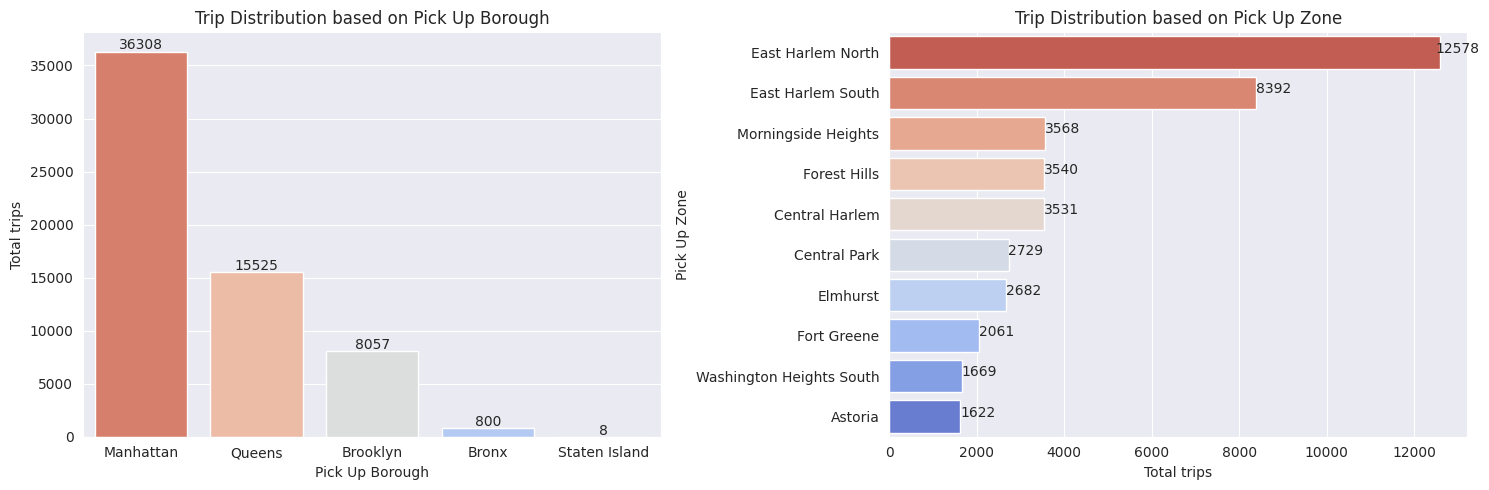

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
bars = sns.barplot(x='PUBorough', y='count', data=agg_borough, palette=scale)
for idx, bar in enumerate(bars.patches):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 200,
             f"{agg_borough['count'].iloc[idx]:.0f}", ha='center')
plt.title('Trip Distribution based on Pick Up Borough')
plt.xlabel('Pick Up Borough')
plt.ylabel('Total trips')

plt.subplot(1, 2, 2)
bars = sns.barplot(x='count', y='PUZone', data=agg_zone.head(10), palette=scale)
for idx, bar in enumerate(bars.patches):
    plt.text(bar.get_width() + 400, bar.get_y() + bar.get_height() / 2,
             f"{agg_zone['count'].iloc[idx]:.0f}", ha='center')
plt.title('Trip Distribution based on Pick Up Zone')
plt.xlabel('Total trips')
plt.ylabel('Pick Up Zone')

plt.tight_layout()
plt.show()


`Insights`

- The highest demand for taxi trips occurred in the Manhattan area with 36 thousand trips, followed by Queens with 15 thousand, Brooklyn with 8 thousand, and State Island with the lowest with only 8 trips.

- Meanwhile, the 10 zones with the highest demand include East Harlem North with 12 thousand, East Harlem South with 8 thousand to Astoria with 1622 trips.

## Amount Distribution

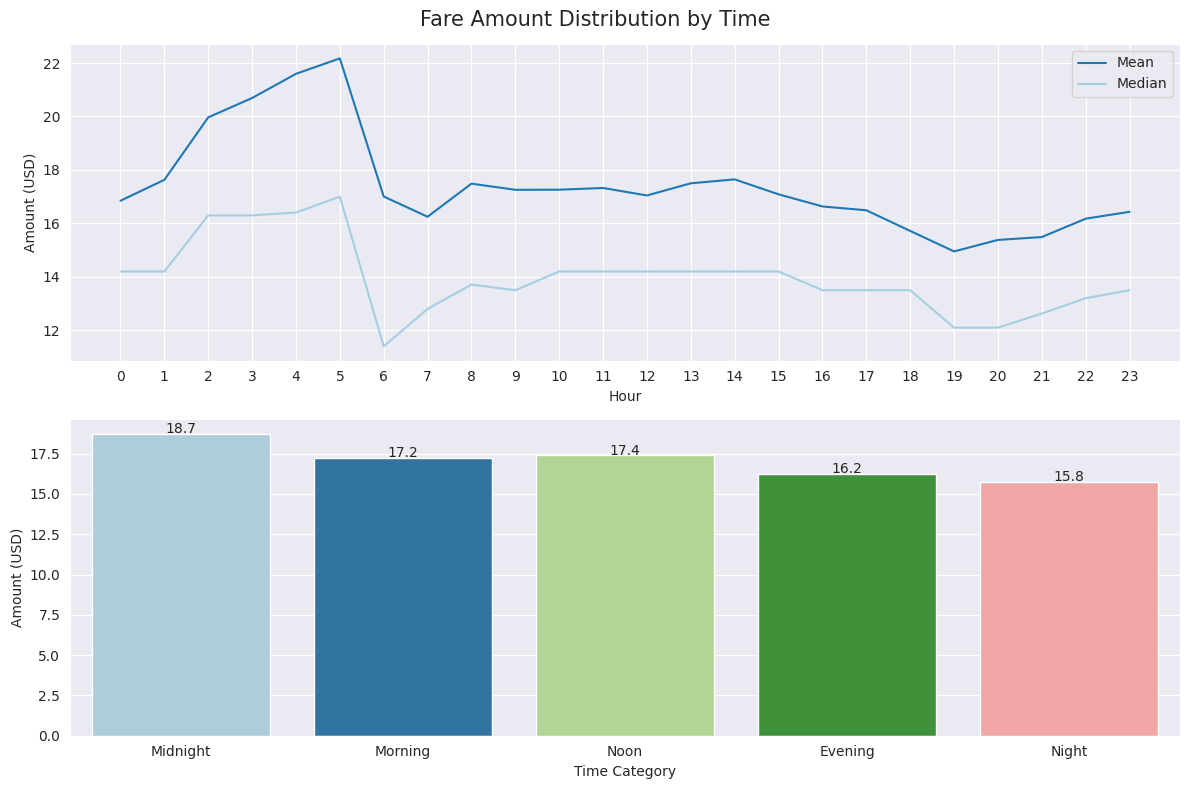

In [ ]:
sort_time = ['Midnight', 'Morning', 'Noon', 'Evening', 'Night']
amount_by_hour = df.groupby(df['lpep_pickup_datetime'].dt.hour).agg(
    total_fare_amount=('fare_amount', 'sum'),
    avg_fare_amount=('fare_amount', 'mean'),
    median_fare_amount=('fare_amount', 'median')
).reset_index()

amount_by_time = (df.groupby('pickup_time')
                  .agg(total_fare_amount=('fare_amount', 'sum'),
                       avg_fare_amount=('fare_amount', 'mean'),
                       median_fare_amount=('fare_amount', 'median'))
                  .reindex(sort_time)
                  .reset_index()
                  .round(2))

plt.figure(figsize=(12, 8))
plt.suptitle('Fare Amount Distribution by Time', fontsize=15)

plt.subplot(2, 1, 1)
sns.lineplot(data=amount_by_hour, x='lpep_pickup_datetime', y='avg_fare_amount', color=color[1], label='Mean')
sns.lineplot(data=amount_by_hour, x='lpep_pickup_datetime', y='median_fare_amount', color=color[0], label='Median')
plt.xlabel('Hour')
plt.xticks(np.arange(0, 24, 1))
plt.ylabel('Amount (USD)')

plt.subplot(2, 1, 2)
bars = sns.barplot(data=amount_by_time, x='pickup_time', y='avg_fare_amount', palette=color)
for idx, bar in enumerate(bars.patches):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
             f"{amount_by_time['avg_fare_amount'].iloc[idx]:.1f}", ha='center')
plt.xlabel('Time Category')
plt.ylabel('Amount (USD)')

plt.tight_layout()
plt.show()


`Insight:`

- The average price for a single trip in the middle of the night, namely 00:00 - 05:00, is relatively more expensive than the others, namely 19 USD.

- The lowest average price for a single trip is at night at 20:00 - 00.00 with an average fare amount of 15 USD.

- While at other times such as morning, afternoon, and evening are relatively the same.

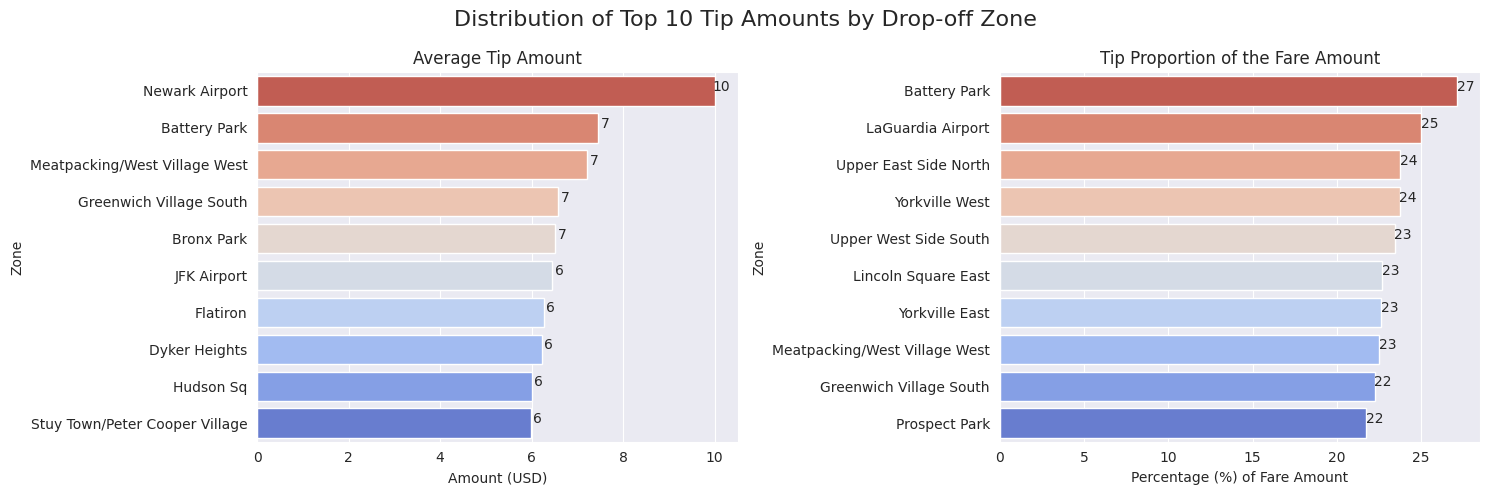

In [ ]:
doloc_tip = df.groupby('DOZone').agg(
    count=('tip_amount', 'count'),
    total_tip=('tip_amount', 'sum'),
    median_tip=('tip_amount', 'median'),
    median_fare=('fare_amount', 'median')
).reset_index()
doloc_tip['proportion_of_tip'] = (doloc_tip['median_tip'] / doloc_tip['median_fare'] * 100).round(2)

plt.figure(figsize=(15, 5))
plt.suptitle('Distribution of Top 10 Tip Amounts by Drop-off Zone', fontsize=16)

top_median_tip = doloc_tip[doloc_tip['count'] > 1].nlargest(10, 'median_tip')
plt.subplot(1, 2, 1)
bars = sns.barplot(data=top_median_tip, x='median_tip', y='DOZone', palette=scale)
plt.title('Average Tip Amount')
plt.xlabel('Amount (USD)')
plt.ylabel('Zone')
for idx, bar in enumerate(bars.patches):
    plt.text(bar.get_width() + 0.15, bar.get_y() + bar.get_height() / 2,
             f"{top_median_tip['median_tip'].iloc[idx]:.0f}", ha='center')

top_proportion_tip = doloc_tip[doloc_tip['count'] > 1].nlargest(10, 'proportion_of_tip')
plt.subplot(1, 2, 2)
bars = sns.barplot(data=top_proportion_tip, x='proportion_of_tip', y='DOZone', palette=scale)
plt.title('Tip Proportion of the Fare Amount')
plt.xlabel('Percentage (%) of Fare Amount')
plt.ylabel('Zone')
for idx, bar in enumerate(bars.patches):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             f"{top_proportion_tip['proportion_of_tip'].iloc[idx]:.0f}", ha='center')

plt.tight_layout()
plt.show()


`Insight:`

- Top 10 highest average tips given by passengers based on the amount of the tip ranging from 6-10 USD with the Newark Airport drop off zone having the last Stuy Town/Peter Cooper Village.

- Top 10 highest average tips given by passengers based on the proportion of the fare amount ranging from 22-27% of the fare_amount with the Battery Park drop off zone having the highest and Prospect Park having the lowest.

## Tip Amount Correlation

In [ ]:
df_tip_corr = df[['PULocationID', 'DOLocationID', 'trip_distance', 'trip_duration', 'speed', 'fare_amount', 'tip_amount']][df['tip_amount']>0]
df_tip_corr.head()

,PULocationID,DOLocationID,trip_distance,trip_duration,speed,fare_amount,tip_amount
0,166,143,2.58,11.02,14.05,14.9,4.03
1,24,43,1.81,6.77,16.04,10.7,2.64
2,41,238,1.30,5.82,13.40,6.5,1.70
5,181,45,3.80,17.42,13.09,19.1,4.85
7,41,166,1.11,4.95,13.45,7.2,1.00


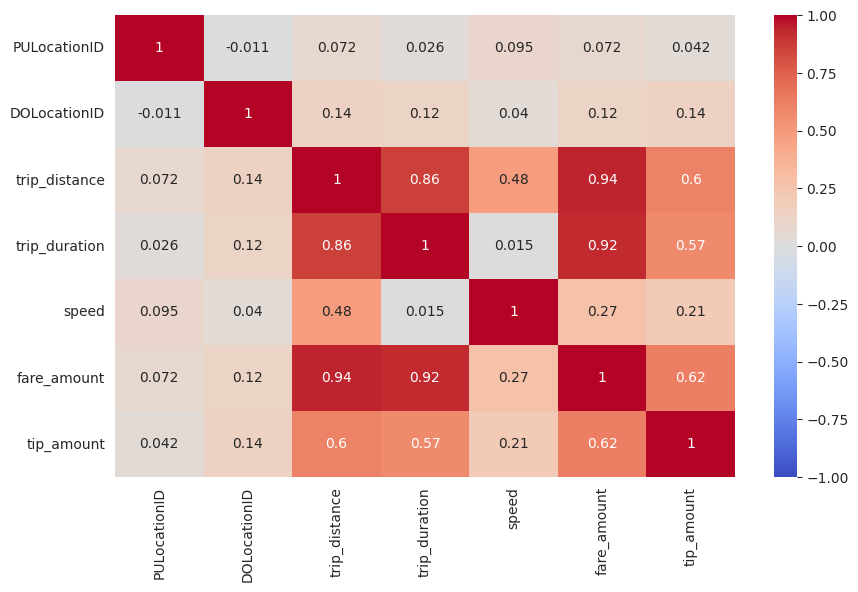

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df_tip_corr.corr('spearman'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

`Insights: `

- `trip_distance with tip_amount (0.6)`:

There is a moderate positive correlation between trip distance and tip amount. This means that the longer the trip distance, the larger the tip given by customers.

- `trip_duration with tip_amount (0.57)`:

There is a moderate positive correlation between trip duration and tip amount. This shows that longer trips tend to get larger tips, although the strength of the correlation is slightly weaker compared to trip_distance.

- `driving_speed with tip_amount (0.21)`:

The correlation between driving speed and tip amount is positive but weak. This means that the driver's speed affects the tip amount, but not as strongly as the other variables. It can be interpreted that driving speed may not be the main factor influencing customers' tipping decisions.

- `fare_amount with tip_amount (0.62)`:

There is a moderate to strong positive correlation between fare amount and tip. This is the strongest correlation among the other variables, indicating that the higher the fare charged, the higher the likelihood of a tip given by the customer.

In conclusion, based on the above correlations, we can say that fare_amount and trip_distance are the two main factors that influence the size of the tip, with fare_amount being slightly more dominant. This makes sense, considering that customers may be more likely to tip based on a percentage of the total fare or based on how far they have been given a ride.

## Significance of Tip Amount to Other Features

### Weekdays or Weekend

In [ ]:
daycat_tip_corr = df[df['tip_amount']>0][['day_category', 'tip_amount']]
ct_tip_daycat = daycat_tip_corr.groupby('day_category').agg(count=('tip_amount', 'count'), avg_tip=('tip_amount', 'mean'), median_tip=('tip_amount', 'median')).round(2).reset_index()
ct_tip_daycat

,day_category,count,avg_tip,median_tip
0,Weekdays,27796,3.69,3.05
1,Weekend,9219,3.76,3.10


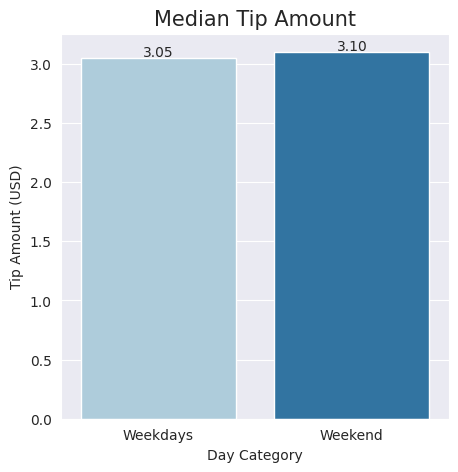

In [ ]:
plt.figure(figsize=(5,5))

bars = sns.barplot(data=ct_tip_daycat, x='day_category', y='median_tip', ci=0, palette=color)
for idx, bar in enumerate(bars.patches):
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 0.01
    label = "{:.2f}".format(ct_tip_daycat['median_tip'].iloc[idx])
    plt.text(x_value, y_value, label, ha='center')

plt.xlabel('Day Category')
plt.ylabel('Tip Amount (USD)')
plt.title('Median Tip Amount', fontsize=15)
plt.show()

**Hypothesis**:

**Ho**: Median tip on weekends = Median tip on weekdays

**Ha**: Median tip on weekends <> Median tip on weekdays

In [ ]:
from scipy.stats import mannwhitneyu

stat, pvalue= mannwhitneyu(
    daycat_tip_corr[daycat_tip_corr['day_category'] == 'Weekend']['tip_amount'].sample(100, random_state=0),
    daycat_tip_corr[daycat_tip_corr['day_category'] == 'Weekdays']['tip_amount'].sample(100, random_state=0),
    alternative='two-sided'
)

print('p-Value', pvalue)

if pvalue > 0.05:
    print('Accept H0')
else:
    print('Reject H0')

p-Value 0.2989890032998106
Accept H0


**Conclusion**:

Based on the available data and at a significance level of 5%, the data provides evidence that the median of `tip values ​​on weekends are the same as the median of tips on weekdays`.

### Pickup Time

In [ ]:
putime_tip_corr = df[df['tip_amount']>0][['pickup_time', 'tip_amount']]
ct_tip_putime = putime_tip_corr.groupby('pickup_time').agg(count=('tip_amount', 'count'), avg_tip=('tip_amount', 'mean'), median_tip=('tip_amount', 'median')).round(2).reset_index()
ct_tip_putime

,pickup_time,count,avg_tip,median_tip
0,Evening,14100,3.69,3.20
1,Midnight,1689,4.09,3.24
2,Morning,8044,3.63,2.88
3,Night,5135,3.56,3.00
4,Noon,8047,3.81,3.14


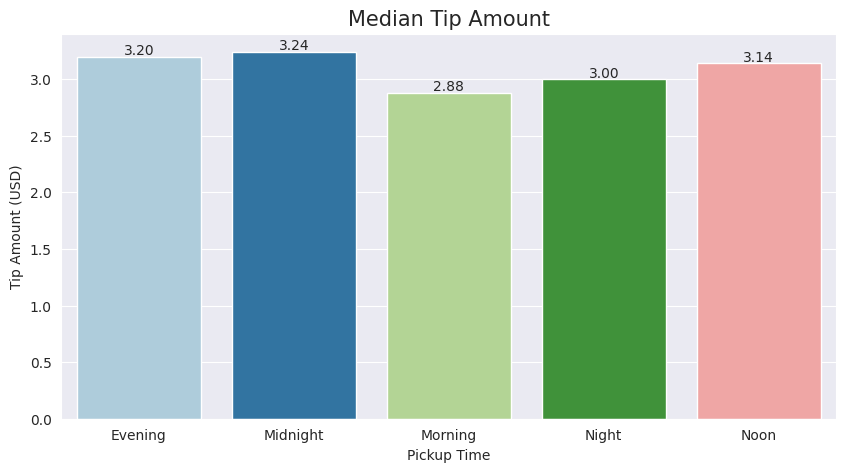

In [ ]:
plt.figure(figsize=(10,5))

bars = sns.barplot(data=ct_tip_putime, x='pickup_time', y='median_tip', ci=0, palette=color)
for idx, bar in enumerate(bars.patches):
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 0.02
    label = "{:.2f}".format(ct_tip_putime['median_tip'].iloc[idx])
    plt.text(x_value, y_value, label, ha='center')

plt.xlabel('Pickup Time')
plt.ylabel('Tip Amount (USD)')
plt.title('Median Tip Amount', fontsize=15)
plt.show()

**Hypothesis:**

**Ho**: Median Tip With In Time Category Midnight = Morning = Noon = Evening = Night

**Ha**: There is at least one pair that is not the same (and we don't know which one)

In [ ]:
from scipy.stats import kruskal

stat, pvalue= kruskal(
    putime_tip_corr[putime_tip_corr['pickup_time'] == 'Midnight']['tip_amount'].sample(100, random_state=0),
    putime_tip_corr[putime_tip_corr['pickup_time'] == 'Morning']['tip_amount'].sample(100, random_state=0),
    putime_tip_corr[putime_tip_corr['pickup_time'] == 'Noon']['tip_amount'].sample(100, random_state=0),
    putime_tip_corr[putime_tip_corr['pickup_time'] == 'Evening']['tip_amount'].sample(100, random_state=0),
    putime_tip_corr[putime_tip_corr['pickup_time'] == 'Night']['tip_amount'].sample(100, random_state=0),
)

print('p-Value', pvalue)

if pvalue > 0.05:
    print('Accept H0')
else:
    print('Reject H0')

p-Value 0.41009687386731164
Accept H0


**Conclusion:**

Based on the data available and at the 5% significance level, there is no significant difference in `tip_amount` between at least two of the pickup time categories. In other words, `pickup time does not affect the tip_amount given by customers`.

### Trip Types

In [ ]:
trip_type_tip_corr = df[df['tip_amount']>0][['trip_type', 'tip_amount']]
ct_tip_trip_type= trip_type_tip_corr.groupby('trip_type').agg(count=('tip_amount', 'count'), avg_tip=('tip_amount', 'mean'), median_tip=('tip_amount', 'median')).round(2).reset_index()
ct_tip_trip_type

,trip_type,count,avg_tip,median_tip
0,Dispatch,237,6.95,5.00
1,Street-hail,36778,3.68,3.05


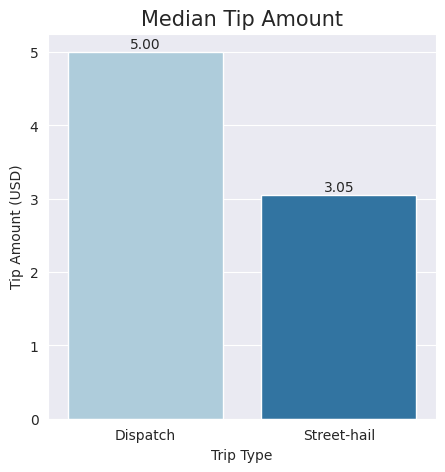

In [ ]:
plt.figure(figsize=(5,5))

bars = sns.barplot(data=ct_tip_trip_type, x='trip_type', y='median_tip', ci=0, palette=color)
for idx, bar in enumerate(bars.patches):
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 0.05
    label = "{:.2f}".format(ct_tip_trip_type['median_tip'].iloc[idx])
    plt.text(x_value, y_value, label, ha='center')

plt.xlabel('Trip Type')
plt.ylabel('Tip Amount (USD)')
plt.title('Median Tip Amount', fontsize=15)

plt.show()

**Hypothesis**:

**Ho**: Median tip on street-hail trip type = Median tip on app trip type

**Ha**: Median tip on street-hail trip type < Median tip on app trip type

In [ ]:
from scipy.stats import mannwhitneyu

stat, pvalue= mannwhitneyu(
    trip_type_tip_corr[trip_type_tip_corr['trip_type'] == 'Street-hail']['tip_amount'].sample(100, random_state=0),
    trip_type_tip_corr[trip_type_tip_corr['trip_type'] == 'Dispatch']['tip_amount'].sample(100, random_state=0),
    alternative='less'
)

print('p-Value', pvalue/2)

if pvalue > 0.05:
    print('Accept H0')
else:
    print('Reject H0')

p-Value 3.7971370699720352e-06
Reject H0


**Conclusion**:

Based on the data available and at a significance level of 5%, the data provides evidence that the median of the `street-hail trip type tip value is smaller than the tip on the app trip type`.

### RateCodeID

In [ ]:
ratecode_tip_corr = df[df['tip_amount']>0][['RatecodeID', 'tip_amount']]
ct_tip_ratecode= ratecode_tip_corr.groupby('RatecodeID').agg(count=('tip_amount', 'count'), avg_tip=('tip_amount', 'mean'), median_tip=('tip_amount', 'median')).round(2).reset_index()
ct_tip_ratecode

,RatecodeID,count,avg_tip,median_tip
0,JFK Airport,124,15.18,15.61
1,Negotiated fare,279,6.47,4.80
2,Newark Airport,7,20.09,21.99
3,Standard rate,36605,3.64,3.05


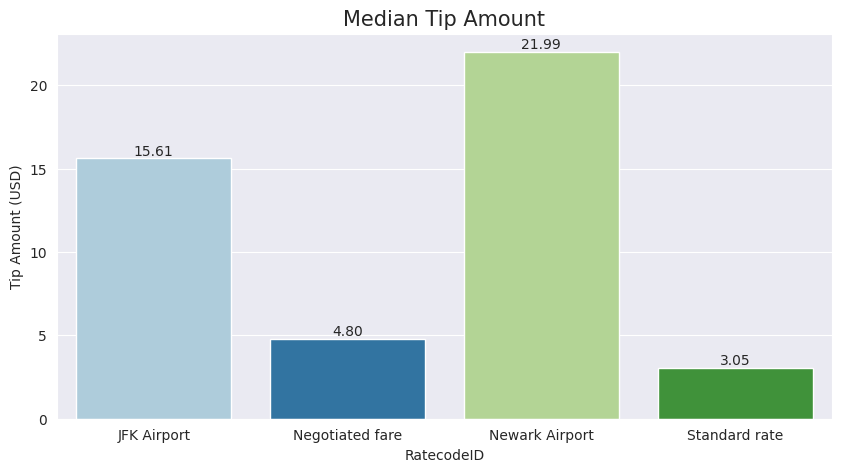

In [ ]:
plt.figure(figsize=(10,5))

bars = sns.barplot(data=ct_tip_ratecode, x='RatecodeID', y='median_tip', ci=0, palette=color)
for idx, bar in enumerate(bars.patches):
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 0.2
    label = "{:.2f}".format(ct_tip_ratecode['median_tip'].iloc[idx])
    plt.text(x_value, y_value, label, ha='center')

plt.xlabel('RatecodeID')
plt.ylabel('Tip Amount (USD)')
plt.title('Median Tip Amount', fontsize=15)
plt.show()

**Hypothesis:**

**Ho**: Median Tip With Ratecode Standard Rate = JFK Airport = Newark Airport = Nassau or Westchester = Negotiated fare

**Ha**: At least one pair is not the same (and we don't know which one)

In [ ]:
from scipy.stats import kruskal

stat, pvalue= kruskal(
    ratecode_tip_corr[ratecode_tip_corr['RatecodeID'] == 'Standard rate']['tip_amount'].sample(7, random_state=0),
    ratecode_tip_corr[ratecode_tip_corr['RatecodeID'] == 'JFK Airport']['tip_amount'].sample(7, random_state=0),
    ratecode_tip_corr[ratecode_tip_corr['RatecodeID'] == 'Newark Airport']['tip_amount'].sample(7, random_state=0),
    ratecode_tip_corr[ratecode_tip_corr['RatecodeID'] == 'Negotiated fare']['tip_amount'].sample(7, random_state=0),
)

print('p-Value', pvalue)

if pvalue > 0.05:
    print('Accept H0')
else:
    print('Reject H0')

p-Value 0.0014288307359390058
Reject H0


**Conclusion:**

Based on the data available and at a significance level of 5%, there is a significant difference in `tip_amount` between at least two of the categories of fare types. In other words, `fare type affects the amount of tip_amount given by passengers`.

### Trip Distance

In [ ]:
tip_distance = df[df['tip_amount']>0][['tip_amount', 'distance_bins']]
ct_tip_distance = tip_distance.groupby('distance_bins').agg(count=('tip_amount', 'count'), avg_tip=('tip_amount', 'mean'), median_tip=('tip_amount', 'median')).reset_index().round(2)
ct_tip_distance

,distance_bins,count,avg_tip,median_tip
0,3-6 miles,15731,4.06,4.00
1,7-10 miles,2920,6.84,7.14
2,<2 miles,17419,2.49,2.44
3,>10 miles,945,10.62,10.55


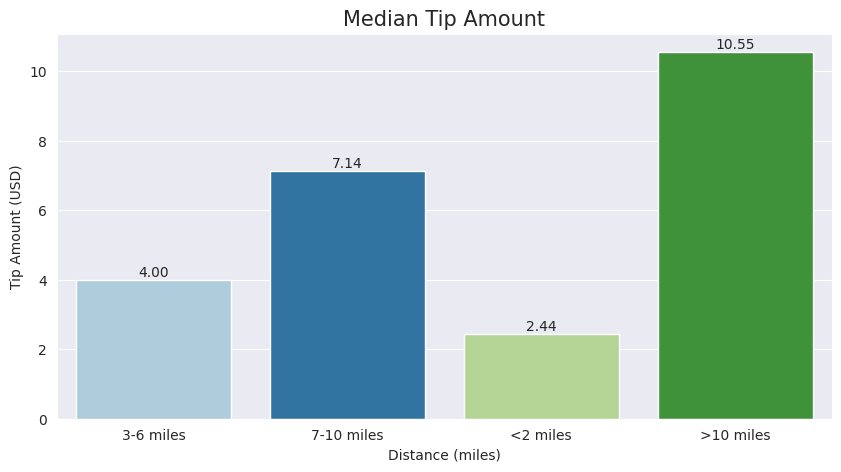

In [ ]:
plt.figure(figsize=(10,5))

bars = sns.barplot(data=ct_tip_distance, x='distance_bins', y='median_tip', ci=0, palette=color)
for idx, bar in enumerate(bars.patches):
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 0.1
    label = "{:.2f}".format(ct_tip_distance['median_tip'].iloc[idx])
    plt.text(x_value, y_value, label, ha='center')

plt.xlabel('Distance (miles)')
plt.ylabel('Tip Amount (USD)')
plt.title('Median Tip Amount', fontsize=15)
plt.show()

**Hypothesis**:

**Ho**: Median tip on trips that have a distance of < 2 miles = 3-6 miles = 7-10 miles => 10 miles

**Ha**: Median tip of one of the distances has a value that is not significantly the same

In [ ]:
from scipy.stats import kruskal

stat, pvalue= kruskal(
    tip_distance[tip_distance['distance_bins'] == '<2 miles']['tip_amount'].sample(100, random_state=0),
    tip_distance[tip_distance['distance_bins'] == '3-6 miles']['tip_amount'].sample(100, random_state=0),
    tip_distance[tip_distance['distance_bins'] == '7-10 miles']['tip_amount'].sample(100, random_state=0),
    tip_distance[tip_distance['distance_bins'] == '>10 miles']['tip_amount'].sample(100, random_state=0)
)

print('p-Value', pvalue)

if pvalue > 0.05:
    print('Accept H0')
else:
    print('Reject H0')

p-Value 1.6599197209973676e-36
Reject H0


**Conclusion**:

Based on the data available and at a significance level of 5%, there is a significant difference in `tip_amount` between at least two of the distance categories. In other words, `Travel distance affects the amount of tip_amount given by customers`.

### Fare Amount

In [ ]:
tip_fare = df[df['tip_amount']>0][['tip_amount', 'fare_amount_bins']]
ct_tip_fare = tip_fare.groupby('fare_amount_bins').agg(count=('tip_amount', 'count'), avg_tip=('tip_amount', 'mean'), median_tip=('tip_amount', 'median')).round(2).reset_index()
ct_tip_fare

,fare_amount_bins,count,avg_tip,median_tip
0,21-40$,7890,5.44,5.46
1,41-60$,1091,8.71,9.43
2,<20$,27696,2.89,2.80
3,>60$,338,14.01,15.60


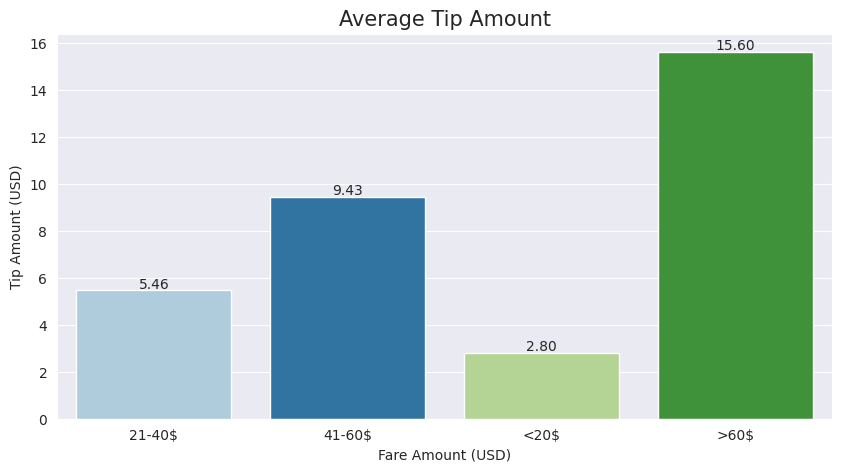

In [ ]:
plt.figure(figsize=(10,5))

bars = sns.barplot(data=ct_tip_fare, x='fare_amount_bins', y='median_tip', ci=0, palette=color)
for idx, bar in enumerate(bars.patches):
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 0.1
    label = "{:.2f}".format(ct_tip_fare['median_tip'].iloc[idx])
    plt.text(x_value, y_value, label, ha='center')

plt.xlabel('Fare Amount (USD)')
plt.ylabel('Tip Amount (USD)')
plt.title('Average Tip Amount', fontsize=15)
plt.show()

**Hypothesis**:

**Ho**: Median tip on fare amount <20 = 21-40 = 41-60 =>60

**Ha**: Median tip of one of the fare_amount groups has a significantly different value

In [ ]:
from scipy.stats import kruskal

stat, pvalue= kruskal(
    tip_fare[tip_fare['fare_amount_bins'] == '<20$']['tip_amount'].sample(100, random_state=0),
    tip_fare[tip_fare['fare_amount_bins'] == '21-40$']['tip_amount'].sample(100, random_state=0),
    tip_fare[tip_fare['fare_amount_bins'] == '41-60$']['tip_amount'].sample(100, random_state=0),
    tip_fare[tip_fare['fare_amount_bins'] == '>60$']['tip_amount'].sample(100, random_state=0)
)

print('p-Value', pvalue)

if pvalue > 0.05:
    print('Accept H0')
else:
    print('Reject H0')

p-Value 9.636778931277564e-37
Reject H0


**Conclusion**:

We have sufficient evidence that at the 5% level of significance, there is a significant difference in `tip_amount` between at least two of the categories of fare amount. In other words, `Fare amount affects the size of the tip_amount given by customers`.

`Insights:`

- There are several factors that influence passengers or customers to give bigger tips.

- These factors include distance, duration, taxi speed, and fare amount, where the greater the distance, duration, taxi speed, and fare amount, the greater the tip given.

- In addition, the type of fare also significantly influences the amount of tip given.

- While time factors such as weekends/weekdays and morning/afternoon/evening/night do not affect the amount of tip given.

# **Fare Prediction**

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
def get_split_sets(train):
    x = train.drop(columns=['fare_amount'])
    y = train['fare_amount'].values
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)
    return x_train, x_val, y_train, y_val

In [64]:
def lin_model(x_train, x_val, y_train, y_val):
    model = LinearRegression()
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    print("MSE:", rmse)
    print("Prediction: ", pred[0:11])
    print("Actuals: ",y_val[0:11])
    return model, rmse, pred


def knn_model(x_train, x_val, y_train, y_val, neighbors):
    min_rmse = 1000
    for n in neighbors:
        knn = KNeighborsRegressor(n_neighbors=n)
        knn.fit(x_train, y_train)
        pred = knn.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        if rmse < min_rmse:
            min_rmse = rmse
            model = knn
            best_pred = pred
        print('Neighbours', n, 'RMSE', rmse)
        print("Prediction: ", pred[0:11])
    print("Actuals: ",y_val[0:11])
    return model, min_rmse, best_pred


def lgbm_model(params,x_train, x_val, y_train, y_val):
    lgbm_train = lgbm.Dataset(x_train, y_train)
    lgbm_val = lgbm.Dataset(x_val, y_val)
    model = lgbm.train(params=params, train_set=lgbm_train, valid_sets=lgbm_val, callbacks=[lgbm.log_evaluation(period=100)])
    pred = model.predict(x_val, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    print("RMSE: ", rmse)
    print("Prediction: ", pred[0:11])
    print("Actuals: ",y_val[0:11])
    return model, rmse, pred

In [68]:
x_train, x_val, y_train, y_val= get_split_sets(df)
lin_init_model, lin_init_rmse, lin_init_pred = lin_model(x_train, x_val, y_train, y_val)

MSE: 2.4367139512502387
Prediction:  [18.59477709 33.88382171 26.25086101  6.61542885 19.74436519 13.56203909
 39.53647798 10.04898188  7.24278967  4.96507421 12.16030498]
Actuals:  [19.1 35.9 28.2  6.5 20.5 17.  45.   9.3  7.2  5.1 10.7]


In [69]:
k_choices = [10,20,30,40,50,60]
knn_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
knn_init, knn_init_rmse, knn_init_pred = knn_model(x_train[knn_cols], x_val[knn_cols], y_train, y_val, k_choices)

Neighbours 10 RMSE 7.8248667892098975
Prediction:  [20.22 29.81 24.7   8.25 14.9  15.32 43.18  9.16  9.93  7.97  9.23]
Neighbours 20 RMSE 7.700385898942501
Prediction:  [21.165 30.58  25.39   8.215 15.46  15.285 44.265  8.6   10.805  8.145
  8.11 ]
Neighbours 30 RMSE 7.7062163276131965
Prediction:  [21.59666667 29.92666667 25.79        9.69666667 15.69333333 15.25
 45.51333333  9.23       11.26        8.43666667  8.5       ]
Neighbours 40 RMSE 7.741036227871483
Prediction:  [22.0925 29.6525 21.3     9.195  15.215  15.25   45.91    9.335  11.4
  8.6175  8.17  ]
Neighbours 50 RMSE 7.769791431674238
Prediction:  [21.55  29.474 18.816  8.922 15.278 15.432 46.344  9.356 11.372  8.572
  8.536]
Neighbours 60 RMSE 7.8066247766048384
Prediction:  [21.31666667 29.39       17.02        9.055      15.25       15.18
 46.75        9.17166667 11.59833333  8.43666667  8.66333333]
Actuals:  [19.1 35.9 28.2  6.5 20.5 17.  45.   9.3  7.2  5.1 10.7]


In [70]:
lgbm_params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 400,
    'learning_rate': 0.1,
    'max_bin': 3000,
    'num_rounds': 5000,
    'early_stopping_rounds': 100,
    'metric' : 'rmse'
}
lgbm_init_model, lgbm_init_rmse, lgbm_init_pred = lgbm_model(lgbm_params, x_train, x_val, y_train, y_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6831
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 17
[LightGBM] [Info] Start training from score 18.244705
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.68168
[200]	valid_0's rmse: 1.6684
[300]	valid_0's rmse: 1.64985
[400]	valid_0's rmse: 1.64363
Early stopping, best iteration is:
[353]	valid_0's rmse: 1.63885
RMSE:  1.638846752530976
Prediction:  [19.6123254  33.01918056 28.18624328  6.82034872 20.39101977 14.78276069
 44.67163231  9.24135118  7.21663471  5.16580424 10.90199717]
Actuals:  [19.1 35.9 28.2  6.5 20.5 17.  45.   9.3  7.2  5.1 10.7]


# Conclusion and Recommendation

**Conclusion:**

Taxi demand is higher on weekdays than on weekends, with the afternoon being the busiest time. Manhattan dominates in terms of trip volume, with inner-city fares being the preferred choice for customers. In addition, the fare and distance of the trip are the main factors that influence the amount of tips given by customers.

**Recommendations:**

`Taxi Fleet Scheduling`:

- Ensure sufficient taxi fleet availability on weekdays, especially between Monday to Friday, with more focus on Wednesday and Thursday.

- Add more fleet in the afternoon from 3:00 PM to 6:00 PM.

- Optimize taxi operations, reduce taxi operations on weekends and during midnight to early morning hours.

`Area Targeting`:

- Increase the number of taxis in Manhattan, Queens, and Brooklyn as they have higher demand compared to other areas.

- Since Brooklyn has higher average fares in the morning, taxi companies should ensure adequate fleet availability in this area during that time.

- Review fleet allocation in low-demand areas such as Staten Island.

- Provide incentives or bonuses for drivers operating in high-demand areas such as Manhattan, Queens, Brooklyn.

- Consider adjusting fares based on demand. For example, increase fares by 1-3% during peak demand on certain days and times.

- Offer promotions or discounts during low demand times, such as late at night or early in the morning, to attract more customers.

`Promotions and Offers`:

- Launch special promotions for payment types with the highest fares.


- Consider offering special discounts or offers during times or areas with lower average fare amounts to attract more customers.

- Offer packages or promotions for longer trips, since these two factors also have a positive correlation with tips.